# Exercises

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

C:\Users\emiel\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


Text(0, 0.5, 'Probability')

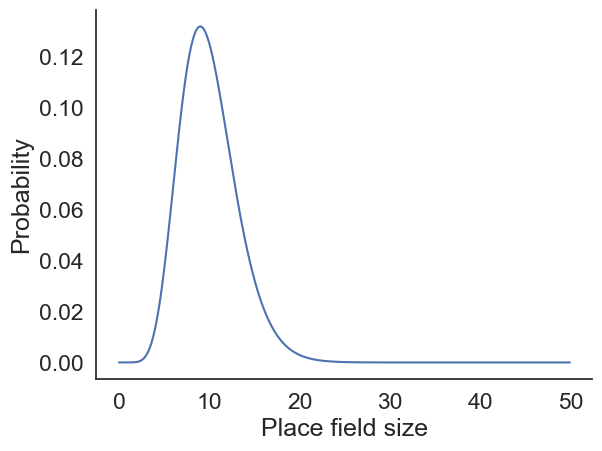

In [2]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

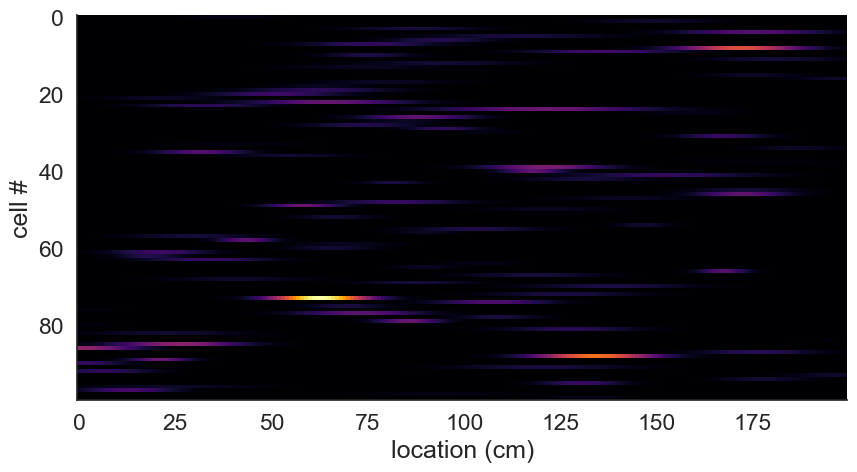

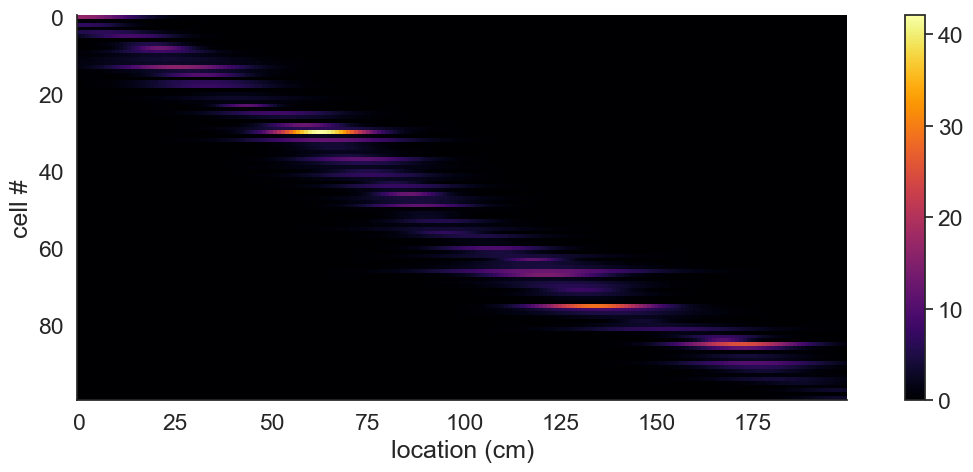

In [3]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

plt.figure(figsize=(10,5))
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Text(0, 0.5, 'position on track (cm)')

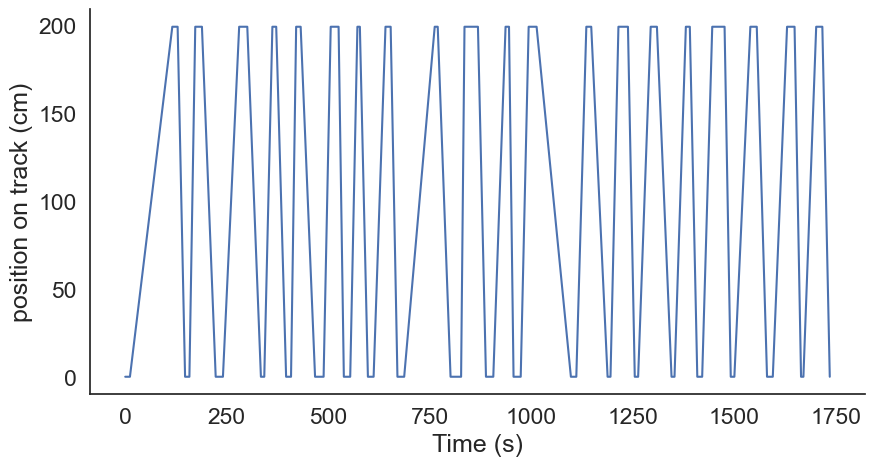

In [4]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

**Code for B**

In [5]:

# B:

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
for noise_firing_rate in [0.01, 0.05, 0.1, 0.5, 1.0]: # the baseline noise firing rate
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    def plot_unit(i):
        plt.figure(figsize=(10,5))
        plt.plot(t, x)
        plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
        plt.title(f'Baseline noise: {noise_firing_rate} Hz, cell #{i}')
        plt.xlabel('Time (s)')
        plt.ylabel('position on track (cm)')
        
    interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

**Code for A**

C:\Users\emiel\AppData\Local\Temp\ipykernel_13532\1561675861.py:17: RuntimeWarning: invalid value encountered in divide
  firing_rate_maps = spikes_hist / occupancy


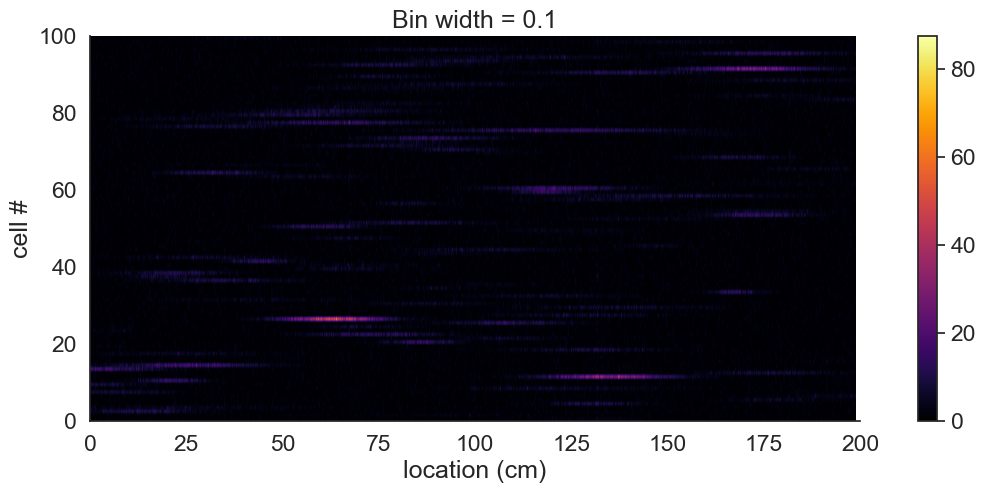

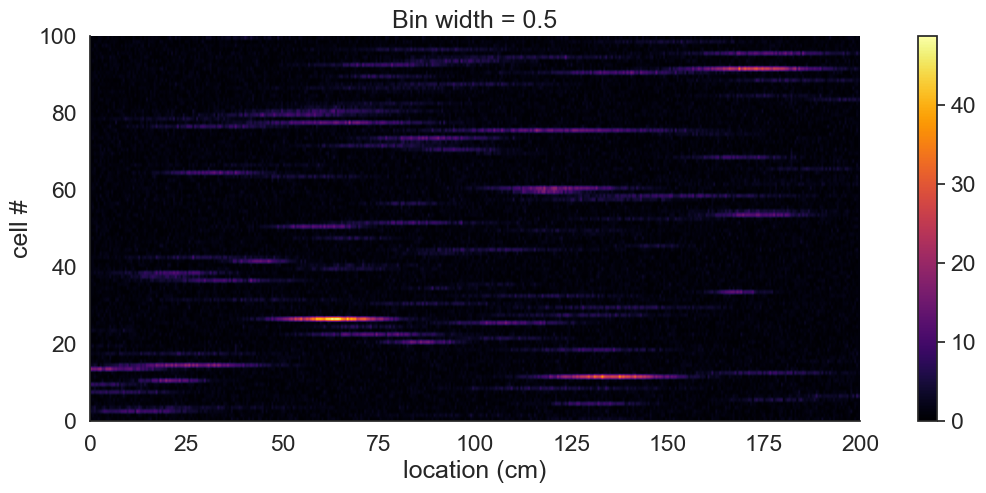

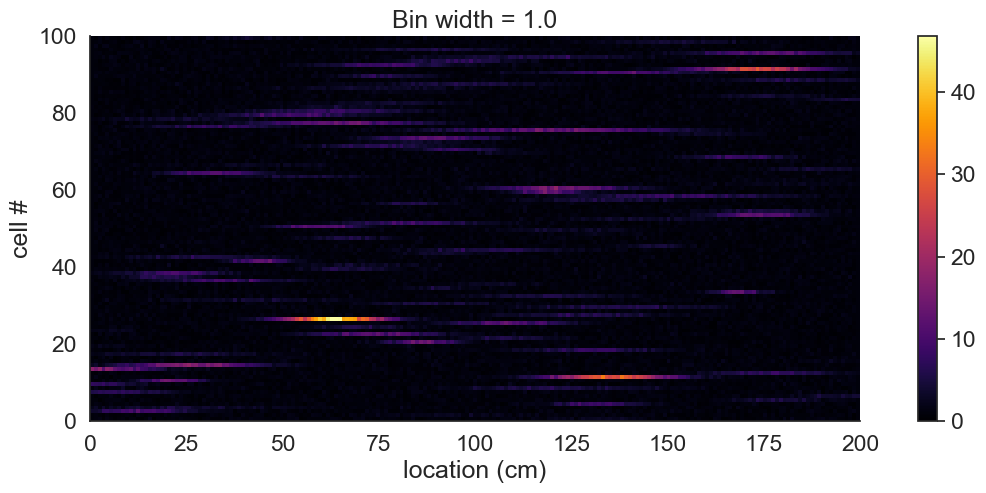

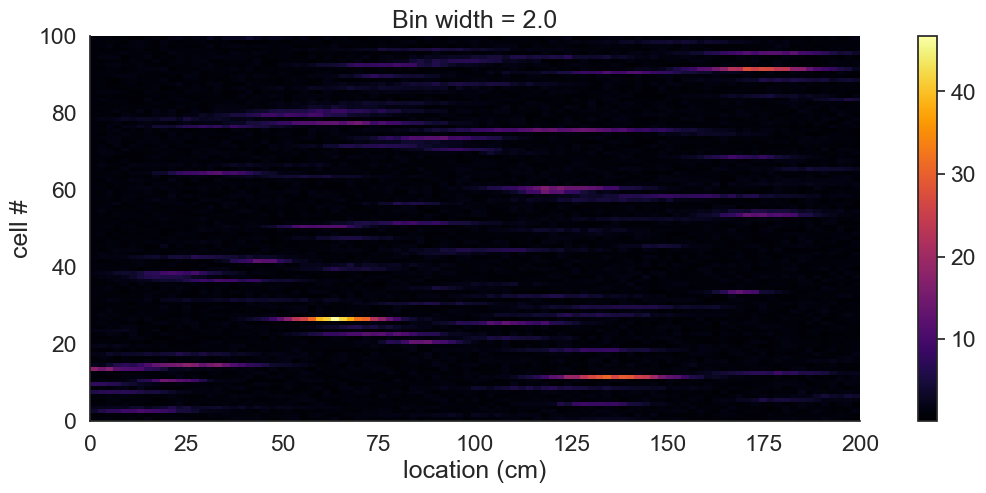

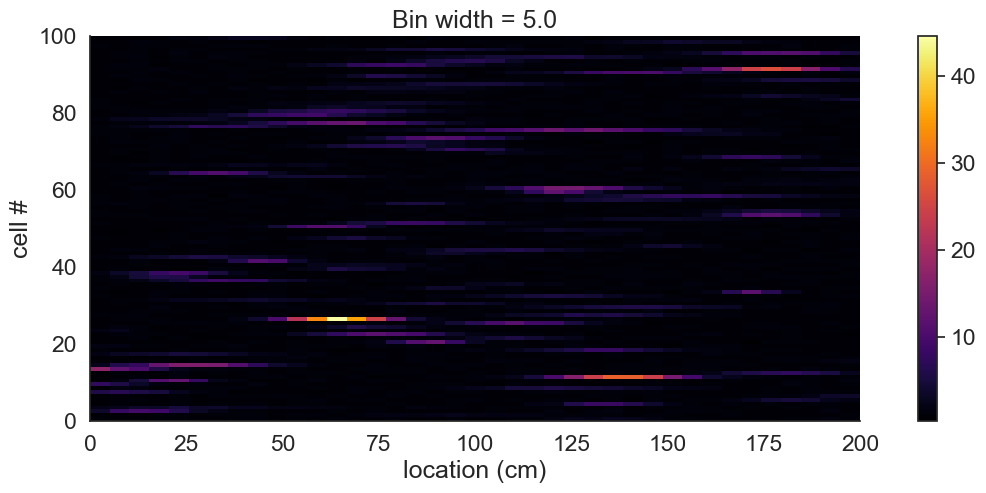

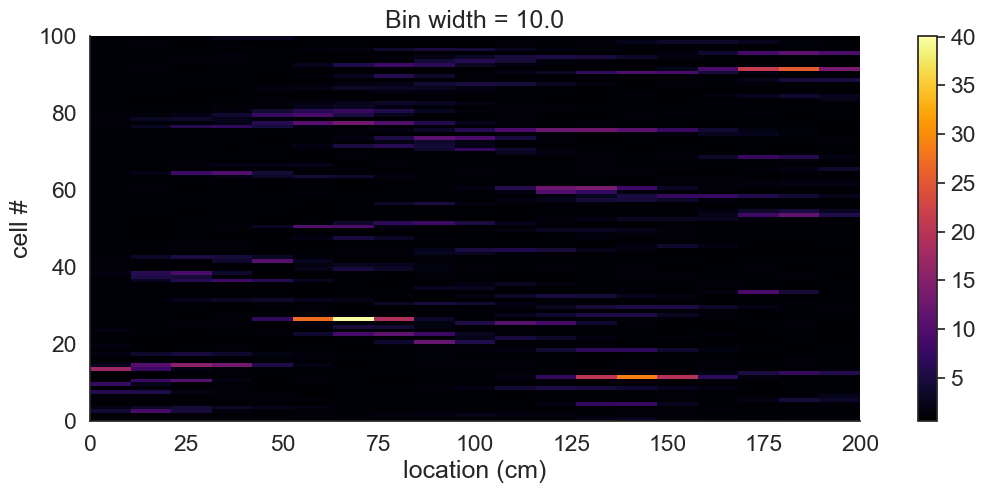

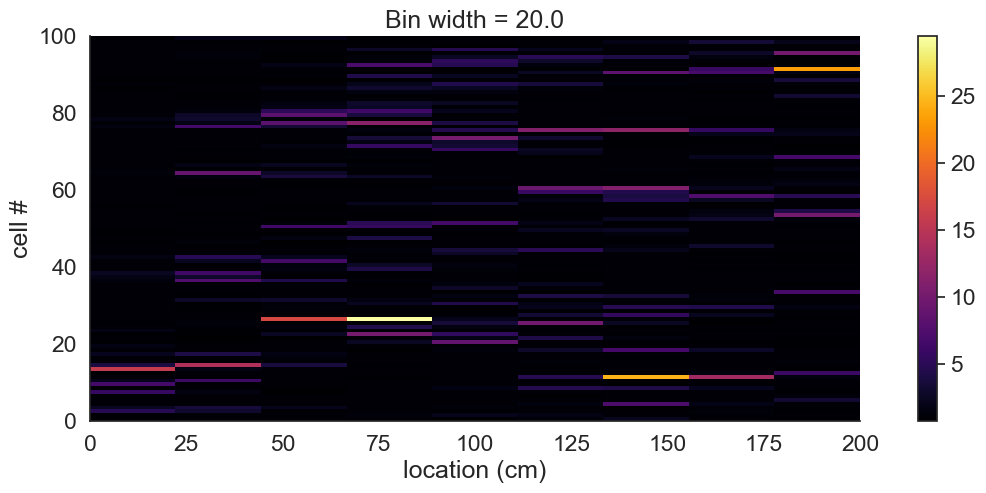

In [7]:
# A:

spike_positions = [np.interp(s, t, x) for s in spikes]

for step in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
    space_bins = np.arange(0., 200., step)

    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    plt.figure(figsize=(15,5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Bin width = {step}')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

In [75]:
from scipy.stats import gaussian_kde

# — assume you’ve already got:
# t, x               # time & position vectors
# spikes             # list of spike-time arrays per cell
# space_bins         # 1D array of bin centers along the track
# occupancy, _       # occupancy histogram (time spent per bin)

def compute_rate_map_kde(spk_times, x, t, space_bins, bandwidth):
    """
    Estimate a firing-rate map via KDE.
    
    spk_times: 1D array of spike timestamps for one cell
    x, t: position & time arrays
    space_bins: positions at which to evaluate the KDE
    bandwidth: kernel width (in same units as x)
    """
    # 1) interpolate spike positions
    spk_pos = np.interp(spk_times, t, x)
    if len(spk_pos) == 0:
        return np.zeros_like(space_bins)
    # 2) fit KDE on spike positions
    kde = gaussian_kde(spk_pos, bw_method=bandwidth/np.std(spk_pos, ddof=1))
    # 3) evaluate and normalize by occupancy (to get rate)
    rate_unnorm = kde(space_bins)
    rate = rate_unnorm / (occupancy + 1e-12)  # avoid div-by-zero
    return rate

# Example: compute KDE maps for each cell
bandwidth = 5.0  # e.g. 5 cm kernel width; tune as needed
kde_rate_maps = []
for cell_spikes in spikes:
    kde_rate_maps.append(
        compute_rate_map_kde(cell_spikes, x, t, space_bins, bandwidth)
    )
kde_rate_maps = np.vstack(kde_rate_maps)

# Plot one example cell alongside its histogram rate map
cell_idx = 0
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axs[0].plot(space_bins, firing_rate_maps[cell_idx], label='histogram')
axs[0].set_title('Histogram rate map')
axs[0].set_xlabel('Location (cm)')
axs[0].set_ylabel('Rate (Hz)')
axs[1].plot(space_bins, kde_rate_maps[cell_idx], label='KDE', color='orange')
axs[1].set_title('KDE-based rate map')
axs[1].set_xlabel('Location (cm)')
plt.tight_layout()
plt.show()

ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

In [ ]:
# C:

from scipy.stats import gaussian_kde

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., 200., 1.)

# we compute histograms for each cell
def apply_kde(s, space_bins):
    bw = 1/np.std(s, ddof=1)
    print(f'Bandwidth for KDE: {bw}')
    kde = gaussian_kde(s, bw_method=1.0)
    return kde(space_bins)

# spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
# print((len(spikes_hist), spikes_hist[0].shape))

spikes_hist = [apply_kde(s, space_bins) for s in spike_positions]
print((len(spikes_hist), spikes_hist[0].shape))

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.title(f'Bin width = {step}')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Bandwidth for KDE: 0.013613833433525005


ValueError: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

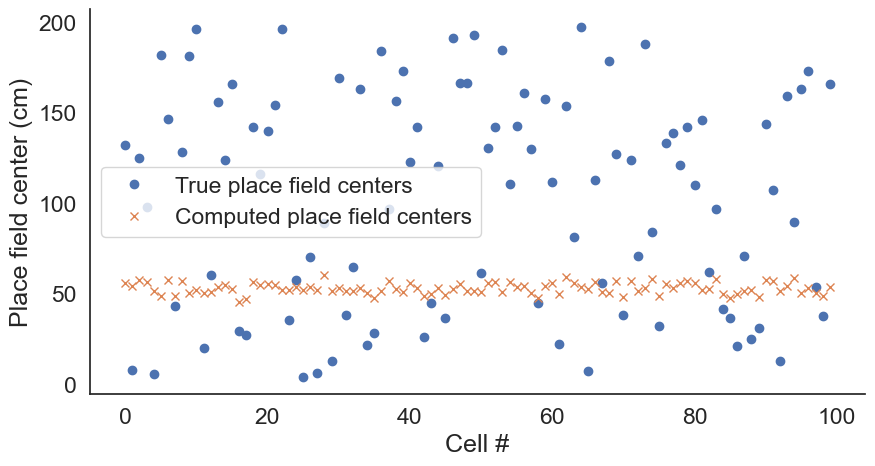

In [57]:
# D:

def c_pf(N_spikes, cell_spikes):
    return (1 / N_spikes) * np.sum(cell_spikes)

spike_positions = [np.interp(s, t, x) for s in spikes]
pf_centers_computed = [c_pf(len(spike_positions[i]), spike_positions[i]) for i in range(n_cells)]
pf_centers_computed = np.array(pf_centers_computed).astype(np.float64)

plt.figure(figsize=(10,5))
plt.plot(pf_centers, 'o', label='True place field centers')
plt.plot(pf_centers_computed, 'x', label='Computed place field centers')
plt.xlabel('Cell #')
plt.ylabel('Place field center (cm)')
plt.legend()
plt.show()

**Exercise 1 Answers**

A: 

B: The noise level is defined by "noise_firing_rate"



D: 

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.

where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 

(same formula as above divided by average firing rate). This second definition favors low-firing rate cells (typical for place cells)

In [72]:
def mutual_information(firing_rate_map, occupancy, epsilon=10e-15):
    lam = np.mean(firing_rate_map)
    print(f'Average firing rate: {lam}')
    f_x = firing_rate_map * np.log2((firing_rate_map + epsilon) / lam) * occupancy
    return np.sum(f_x, axis=0)

(100, 199)
(199,)
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average firing rate: nan
Average

C:\Users\emiel\AppData\Local\Temp\ipykernel_16460\1640266170.py:15: RuntimeWarning: invalid value encountered in divide
  firing_rate_maps = spikes_hist / occupancy


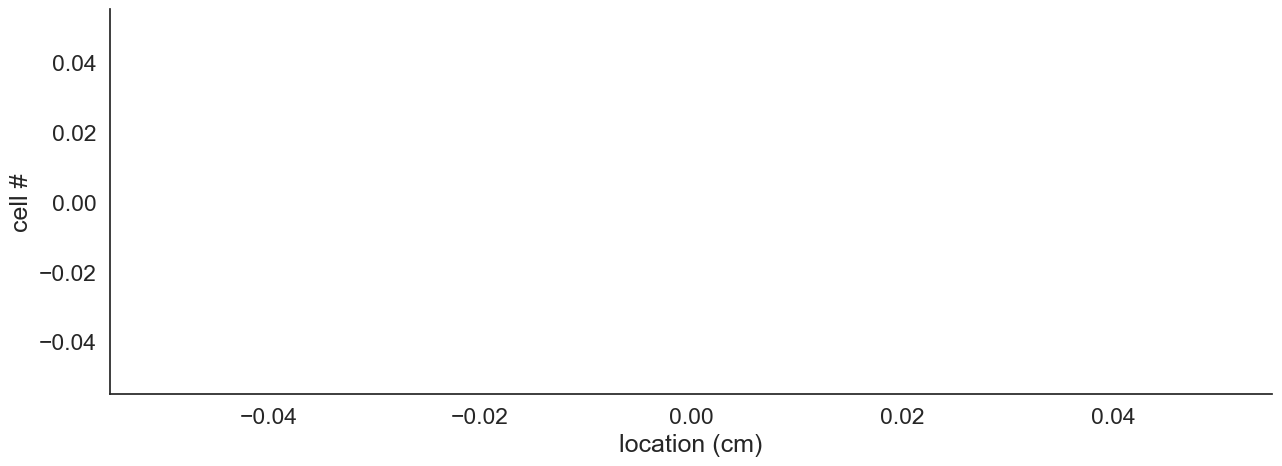

In [73]:
# A:

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., 200., 1.)

spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

print(firing_rate_maps.shape)
print(occupancy.shape)
Is = [mutual_information(firing_rate_maps[i,:], occupancy) for i in range(firing_rate_maps.shape[0])]
print(Is)

plt.figure(figsize=(15,5))
plt.plot(Is)
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.show()

In [ ]:
def systematic_simulation(peak_firing_rate, place_field_size, noise_firing_rate):
    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = 100 # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(place_field_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=peak_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
    g = scipy.stats.gamma.pdf(x, 10)

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 30 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))

    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)





## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [ ]:
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

print(data.keys())

x = data['x']
t = data['t']
spikes = data['spikes']

dict_keys(['x', 't', 'spikes'])


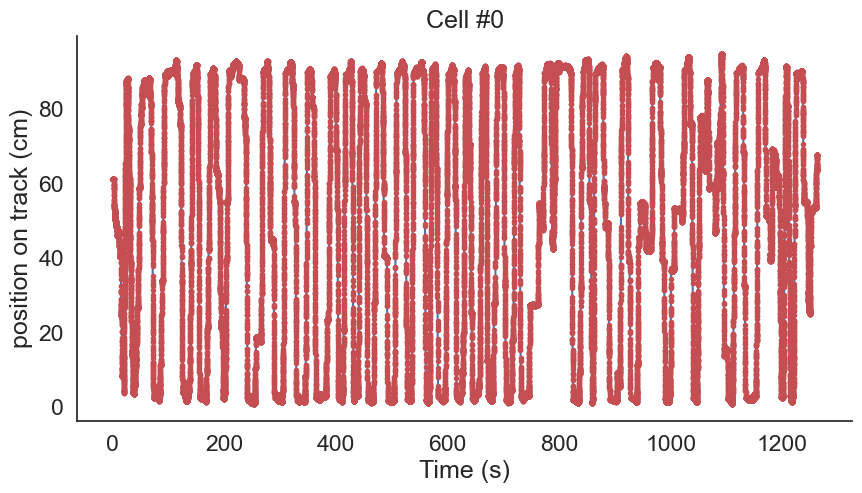

In [19]:
# A:

def plot_cell(t, x, spikes, cell):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[cell], np.interp(spikes[cell], t, x), 'r.')
    plt.title(f'Cell #{cell}')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')


plot_cell(t, x, spikes, 0)

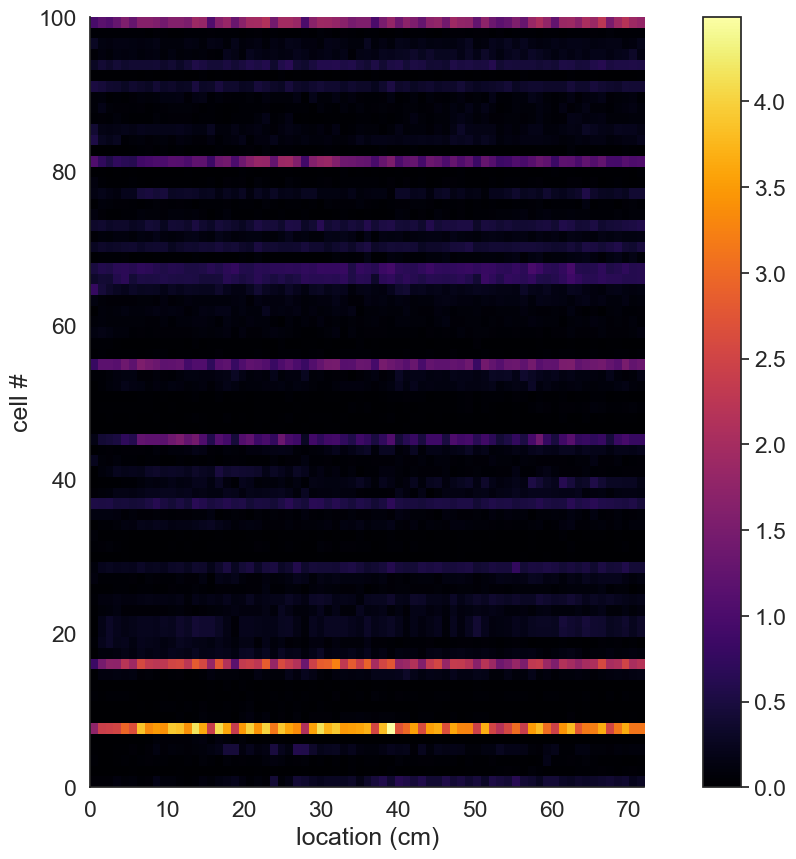

In [29]:
# B:

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., len(spikes), 1.0)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist_sorted = sorted(spikes_hist, key=lambda x: np.argmax(x))
# peak_positions = np.argmax(spikes_hist, axis=1)
# ix = np.argsort(peak_positions)

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist_sorted = np.vstack(spikes_hist_sorted).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] # /  fps

firing_rate_maps = spikes_hist_sorted / occupancy 

plt.figure(figsize=(15,10))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, len(spikes), 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

In [ ]:
# C:

